# produce figure 1a - Cladogram and list of haplogroup indices

In [4]:
%run setup.ipynb
%matplotlib inline
import hapclust

### data set up 

In [5]:
# obtain data from unphased callset - only needed for variant annotations
callset = phase1_ar31.callset
pos_all = allel.SortedIndex(callset['2L/variants/POS'])
ann_all = callset['2L/variants/ANN'][:][['Annotation', 'HGVS_p', 'HGVS_c']]
ann_all.shape

(19453287,)

In [6]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
genotypes_phased.shape, pos_phased.shape

((8296600, 773, 2), (8296600,))

In [7]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [8]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [9]:
# chop genotypes to region, remove colony parents (8 samples) and turn into haplotype array
gen_phased_region = genotypes_phased[loc_region][:, :-8].compute()
gen_phased_region.shape
# don't turn in .to_haplotypes() yet - might be easier to interleave new positions first, then turn whole lot into hap

(163963, 765, 2)

#### grab mvncalls
- mvn 200 should be the 'best' as the algorithm uses the most data when phasing

In [10]:
#genotypes
mvn_200 = np.load('../data/phasing_extra_phase1.mvncall.200.npz')
call_mvn = mvn_200['calldata']
gen_mvn = allel.GenotypeArray(call_mvn['genotype'])

#positions
pos_mvn = allel.SortedIndex(mvn_200['variants']['POS'])
pos_mvn

0,1,2
2391228,2400071,2429745


In [11]:
gen_mvn

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,2/0,0/0,0/0,0/2,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,1/0,0/0,1/1,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


### weave mvncalls into the phased ar3.1 dataset

In [12]:
#concatenate old and new gen/pos arrays
haps_combined = np.concatenate([gen_phased_region, gen_mvn], axis=0)
pos_combined = np.concatenate([pos_phased_region, pos_mvn], axis=0)

In [13]:
#sort pos indices
idx_sorted =np.argsort(pos_combined)

In [14]:
#use sorted indices to re-order the combined arrays
haps_combined = allel.GenotypeArray(haps_combined[idx_sorted])
haps_combined.shape

(163966, 765, 2)

In [15]:
pos_combined = allel.SortedIndex(pos_combined[idx_sorted])
pos_combined.shape

(163966,)

In [16]:
#then turn into haplotype array...
haps = haps_combined.to_haplotypes()
haps

<HaplotypeArray shape=(163966, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

#### tie in annotations

In [17]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_all.locate_intersection(pos_combined)
np.count_nonzero(loc1)

163966

In [18]:
ann_combined = ann_all[loc1]
ann_combined

array([(b'intergenic_region', b'.', b'.'),
       (b'intergenic_region', b'.', b'.'),
       (b'intergenic_region', b'.', b'.'), ...,
       (b'downstream_gene_variant', b'.', b'n.*3149C>T'),
       (b'downstream_gene_variant', b'.', b'n.*3149T>C'),
       (b'downstream_gene_variant', b'.', b'n.*3149C>T')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14'), ('HGVS_c', 'S12')])

In [19]:
collections.Counter(ann_combined['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5808,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [20]:
# perform allele count - needed to locate singletons  
# ignore multiallelics here (but only here) - just use max_allele=1 
# - otherwise it would could the 3rd allele as minor which isn't helpful most of the time
ac_combined = haps.count_alleles(max_allele=3)
ac_combined[:1]

,0,1,2,3
0,1529,1,0,0


### setup missense variation

In [21]:
# convenience, define the Vgsc gene region
region_vgsc = SeqFeature('2L', 2358158, 2431617, label='Vgsc')
region_vgsc

<SeqFeature 'Vgsc' 2L:2358158-2431617>

In [22]:
loc_vgsc = pos_combined.locate_range(region_vgsc.start, region_vgsc.end)
loc_vgsc

slice(24471, 26184, None)

In [23]:
haps_vgsc = haps[loc_vgsc]

In [24]:
ac_vgsc = haps_vgsc.count_alleles(max_allele=2)

In [25]:
ac_vgsc

<AlleleCountsArray shape=(1713, 3) dtype=int32>
1529    1    0
1457   73    0
1528    2    0
...
1513   17    0
1525    5    0
1519   11    0

In [26]:
ann_vgsc = ann_combined[loc_vgsc]
ann_vgsc.shape

(1713,)

In [27]:
loc_vgsc_missense = (ann_vgsc['Annotation'] == b'missense_variant') & (ac_vgsc[:, 1] > 7)
np.count_nonzero(loc_vgsc_missense)

19

In [28]:
loc_vgsc_missense.shape

(1713,)

In [29]:
haps_vgsc_missense = haps_vgsc[loc_vgsc_missense]

In [30]:
haps_vgsc_missense

<HaplotypeArray shape=(19, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 2 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [31]:
#lbl_vgsc_missense = [l[2:] for l in ann_vgsc[loc_vgsc_missense]['HGVS_p'].astype('U')]
lbl_vgsc_missense = ['%s (%s)' % (str(t, 'ascii')[2:], str(s, 'ascii')[2:]) for s, t in zip(ann_vgsc[loc_vgsc_missense][:]['HGVS_c'], ann_vgsc[loc_vgsc_missense][:]['HGVS_p'])]
lbl_vgsc_missense

['Arg254Lys (761G>A)',
 'Val402Leu (1204G>C)',
 'Asp466His (1396G>C)',
 'Met490Ile (1470G>A)',
 'Thr791Met (2372C>T)',
 'Leu995Ser (2984T>C)',
 'Leu995Phe (2985A>T)',
 'Ala1125Val (3374C>T)',
 'Ile1527Thr (4580T>C)',
 'Asn1570Tyr (4708A>T)',
 'Glu1597Gly (4790A>G)',
 'Ala1746Ser (5236G>T)',
 'Val1853Ile (5557G>A)',
 'Ile1868Thr (5603T>C)',
 'Pro1874Ser (5620C>T)',
 'Pro1874Leu (5621C>T)',
 'Phe1920Ser (5759T>C)',
 'Ala1934Val (5801C>T)',
 'Ile1940Thr (5819T>C)']

In [32]:
#need to fix the labels for the two multiallelics - SnfEff only annotates the first alt
#first find them to check what they are
alt_all = callset['2L/variants/ALT'][:]
alt_all.shape

(19453287, 3)

In [33]:
#squish
alt_combined = alt_all[loc1]
alt_combined.shape

(163966, 3)

In [34]:
#squish more
alt_vgsc = alt_combined[loc_vgsc]
alt_vgsc.shape

(1713, 3)

In [35]:
#final squish
alt_vgsc_missense = alt_vgsc[loc_vgsc_missense]
alt_vgsc_missense.shape

(19, 3)

In [36]:
#lets have a look
alt_vgsc_missense

array([[b'A', b'', b''],
       [b'C', b'T', b''],
       [b'C', b'', b''],
       [b'A', b'T', b''],
       [b'T', b'', b''],
       [b'C', b'', b''],
       [b'T', b'', b''],
       [b'T', b'', b''],
       [b'C', b'', b''],
       [b'T', b'', b''],
       [b'G', b'', b''],
       [b'T', b'', b''],
       [b'A', b'', b''],
       [b'C', b'', b''],
       [b'T', b'', b''],
       [b'T', b'', b''],
       [b'C', b'', b''],
       [b'T', b'', b''],
       [b'C', b'', b'']], 
      dtype='|S1')

In [37]:
#add the extra alleles
lbl_vgsc_missense[1] = 'Val402Leu (1204G>C/T)'
lbl_vgsc_missense[3] = 'Met490Ile (1470G>A/T)'

In [38]:
#check
lbl_vgsc_missense

['Arg254Lys (761G>A)',
 'Val402Leu (1204G>C/T)',
 'Asp466His (1396G>C)',
 'Met490Ile (1470G>A/T)',
 'Thr791Met (2372C>T)',
 'Leu995Ser (2984T>C)',
 'Leu995Phe (2985A>T)',
 'Ala1125Val (3374C>T)',
 'Ile1527Thr (4580T>C)',
 'Asn1570Tyr (4708A>T)',
 'Glu1597Gly (4790A>G)',
 'Ala1746Ser (5236G>T)',
 'Val1853Ile (5557G>A)',
 'Ile1868Thr (5603T>C)',
 'Pro1874Ser (5620C>T)',
 'Pro1874Leu (5621C>T)',
 'Phe1920Ser (5759T>C)',
 'Ala1934Val (5801C>T)',
 'Ile1940Thr (5819T>C)']

## split up haplotype data
Here we divide haplotype data up into two, with an "EHH" set containing no singletons and only neutral biallelic variants, which we'll use for analysis of haplotype sharing, and a "mut" set containing singletons and putatively non-neutral bi-allelic variants that we will use for analysis of mutations on shared haplotypes.

In [39]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_combined['Annotation'] == b'intergenic_region') | 
                    (ann_combined['Annotation'] == b'intron_variant') |
                    (ann_combined['Annotation'] == b'downstream_gene_variant') |
                    (ann_combined['Annotation'] == b'upstream_gene_variant') |
                    (ann_combined['Annotation'] == b'synonymous_variant') |
                    (ann_combined['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_combined['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163966,))

In [40]:
# locate singletons - will exclude from EHH analysis
#NB the EHH analysis doesn't need the multiallelics - we've excluded them from the ac_combined
loc_sgl_bi = (ac_combined[:,:2].min(axis=1) == 1) & (ac_combined.is_biallelic_01())

loc_nosgl_bi = (ac_combined[:,:2].min(axis=1) > 1) & (ac_combined.is_biallelic_01())
np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape

(52218, 111615, (163966,))

In [41]:
# these are the variants to use for EHH - missing var are multiallelics
loc_ehh = loc_type_neutral & loc_nosgl_bi
np.count_nonzero(loc_ehh), loc_ehh.shape

(107533, (163966,))

In [42]:
# these are the variants to use for mutational distance
# include non-neutral mutations
loc_mut = loc_sgl_bi | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(56312, (163966,))

In [43]:
haps_mut = haps[loc_mut]
pos_mut = pos_combined[loc_mut]

In [44]:
haps_mut

<HaplotypeArray shape=(56312, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [45]:
haps_ehh = haps[loc_ehh]
pos_ehh = pos_combined[loc_ehh]

In [46]:
#check
pos_mut.locate_key(pos_kdr_s), pos_mut.locate_key(pos_kdr_f)

(10212, 10213)

In [47]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


## split flanks
split haplotype data into L/R flanks on kdr position

In [48]:
#set core SNP
core_pos = pos_kdr_f

In [49]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [50]:
# these give the distance from the core position to each downstream variant, moving away from the core
dist_ehh_right

array([     45,     255,     258, ..., 1574721, 1574726, 1574734], dtype=int32)

In [51]:
dist_ehh_right.shape, dist_ehh_left.shape, dist_ehh_right.min(), dist_ehh_left.min()

((91779,), (15754,), 45, 108)

In [52]:
# split the mutations dataset
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(haps_mut, pos_mut, core_pos)

In [53]:
dist_mut_right

array([      0,      82,     353, ..., 1574719, 1574720, 1574729], dtype=int32)

In [54]:
dist_mut_right.shape, dist_mut_left.shape, dist_mut_right.min(), dist_mut_left.min()

((46099,), (10213,), 0, 1)

In [55]:
haps_ehh_left.shape, haps_ehh_right.shape, haps_mut_left.shape, haps_mut_right.shape

((15754, 1530), (91779, 1530), (10213, 1530), (46099, 1530))

In [56]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

## analyse maximal haplotype sharing ("nearest neighbour" analysis based on prefix sorting)
- nspl = neighbour sharing prefix length
- nspd = neighbour shared physical distance

In [57]:
idx_sorted_right, nspl_right, nspd_right, muts_right = hapclust.neighbour_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right)

In [58]:
idx_sorted_left, nspl_left, nspd_left, muts_left = hapclust.neighbour_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left)

In [59]:
nspl_right.min(), nspl_right.max()

(0, 89166)

In [60]:
nspd_right.min(), nspd_right.max(), nspd_left.min(), nspd_left.max()

(45, 1544571, 108, 2377961)

In [61]:
muts_right.min(), muts_right.max(), muts_left.min(), muts_left.max()

(0, 14, 0, 15)

In [62]:
# compute accessible lengths - needed for mutation analysis
nspd_right_accessible = hapclust.haplotype_accessible_length(nspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nspd_left_accessible = hapclust.haplotype_accessible_length(nspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

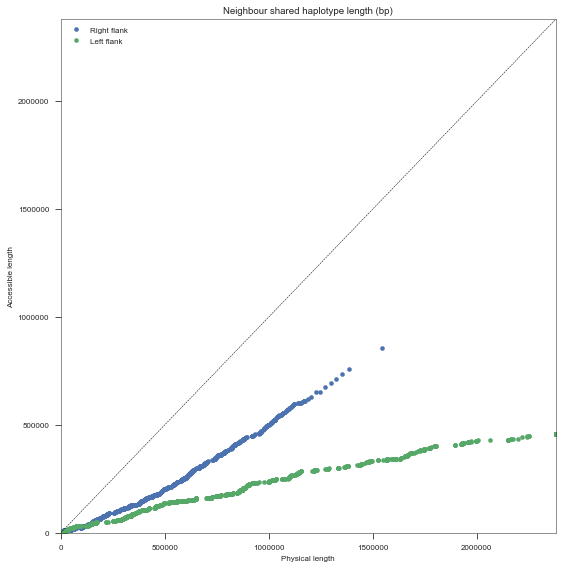

In [63]:
# get some diagnostics on accessibility on left versus right flanks
fig, ax = plt.subplots(figsize=(8, 8))
x = nspd_right
y = nspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = nspd_left
y = nspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Neighbour shared haplotype length (bp)')
fig.tight_layout();

In [64]:
# 1 cM/Mb convert to M/bp
1 / (1e2 * 1e6)

1e-08

In [65]:
# assume constant recombination rate
rr_right = 1.5e-8
# adjust recombination rate on left flank (factor derived from pairwise analysis below)
rr_left = rr_right * 0.37

# assumed mutation rate
mu_right = 3.5e-9
# adjust mutation rate on left flank (factor derived from pairwise analysis below)
mu_left = mu_right * 0.61

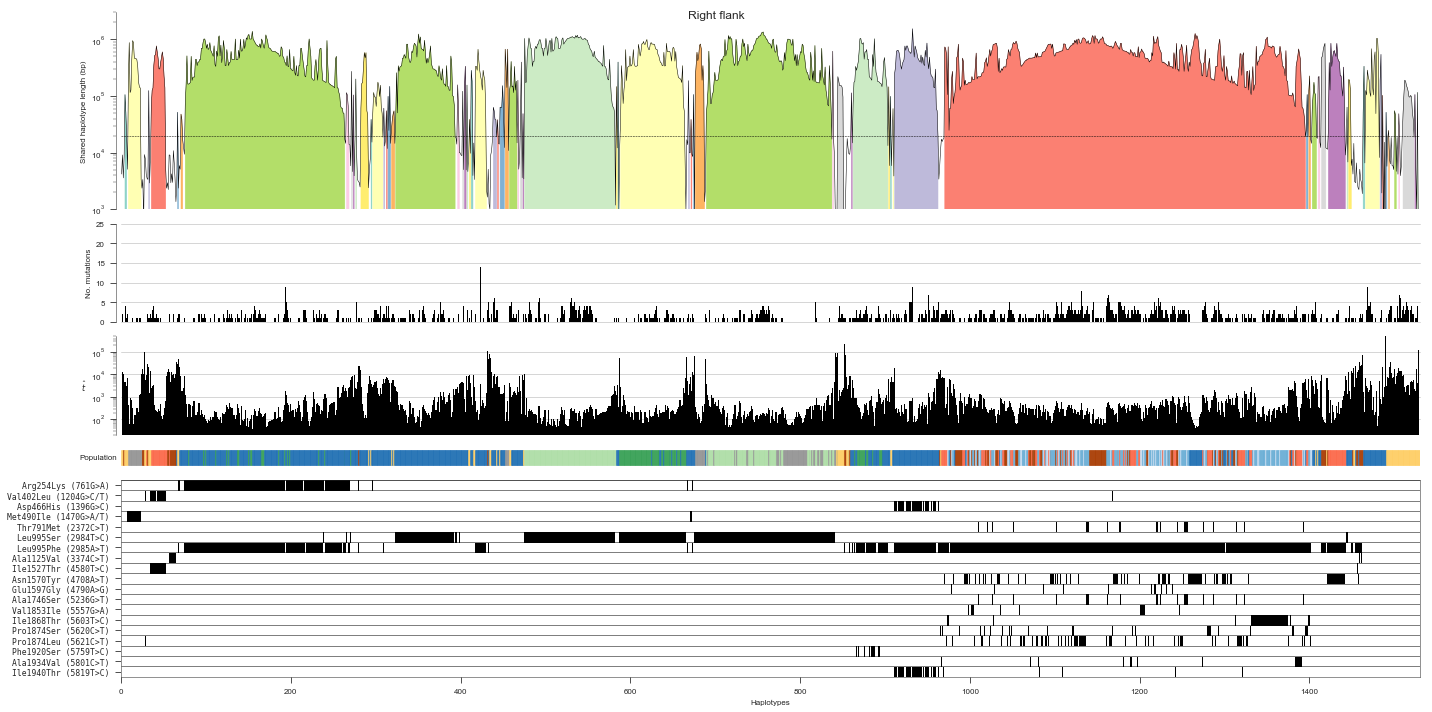

In [66]:
pops_right = df_haplotypes.population[idx_sorted_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]

fig = plt.figure(figsize=(20, 10))
hapclust.fig_neighbour_haplotype_sharing(nspd=nspd_right, 
                                         nspd_accessible=nspd_right_accessible,
                                         muts=muts_right, 
                                         haps_display=haps_vgsc_missense[:, idx_sorted_right],
                                         haps_display_vlbl=lbl_vgsc_missense,
                                         pop_colors=pop_colors_right,
                                         nspd_cut=2e4,
                                         nspd_ylim=(1e3, 3e6),
                                         that_ylim=(2e1, 5e5),
                                         muts_ylim=(0, 25),
                                         mu=mu_right, rr=rr_right,
                                         fig=fig)
fig.suptitle('Right flank');

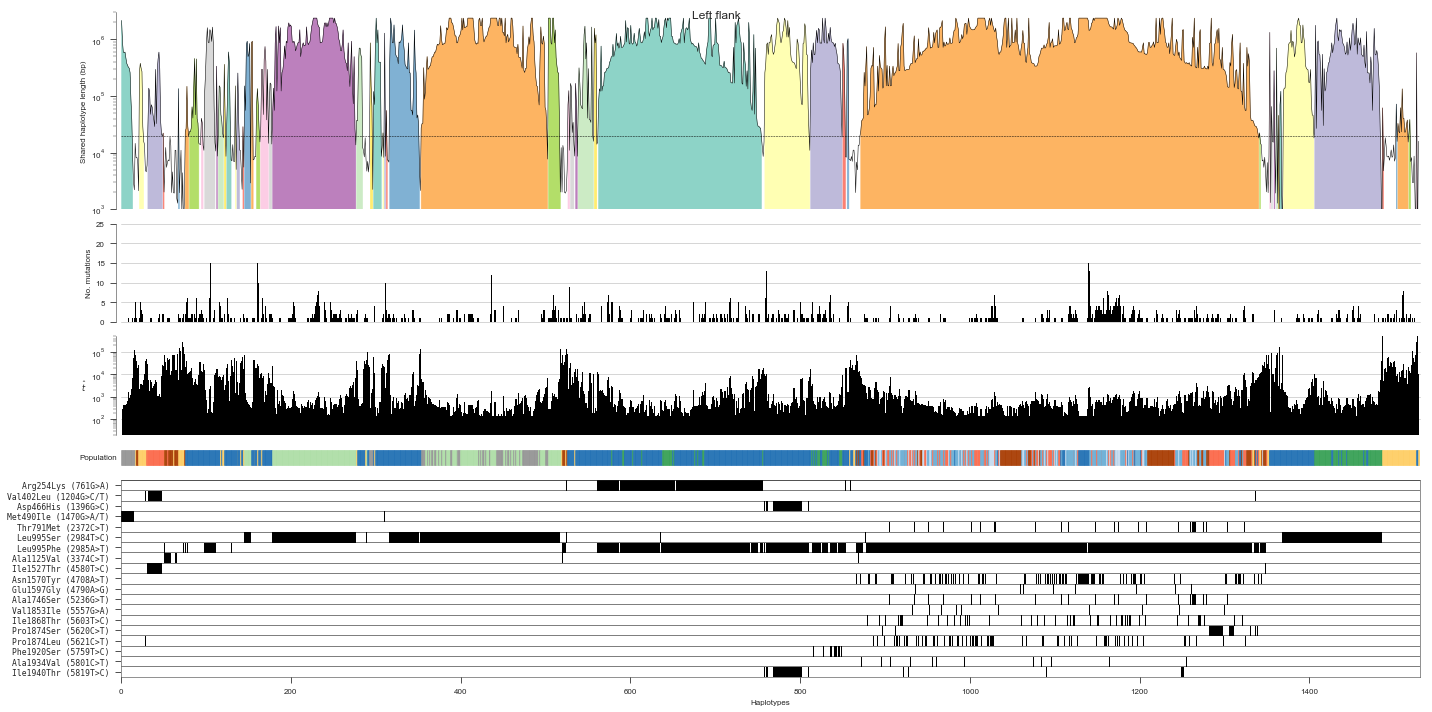

In [67]:
pops_left = df_haplotypes.population[idx_sorted_left]
pop_colors_left = [phase1_ar3.pop_colors[p] for p in pops_left]

fig = plt.figure(figsize=(20, 10))
hapclust.fig_neighbour_haplotype_sharing(nspd=nspd_left, 
                                         muts=muts_left, 
                                         nspd_accessible=nspd_left_accessible,
                                         haps_display=haps_vgsc_missense[:, idx_sorted_left],
                                         haps_display_vlbl=lbl_vgsc_missense,
                                         pop_colors=pop_colors_left,
                                         nspd_cut=2e4,
                                         nspd_ylim=(1e3, 3e6),
                                         that_ylim=(2e1, 5e5),
                                         muts_ylim=(0, 25),
                                         mu=mu_left, rr=rr_left,
                                         fig=fig)
fig.suptitle('Left flank');

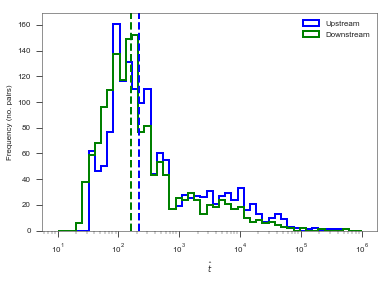

In [68]:
# get some diagnostics on estimates of t hat on left versus right flanks

fig = plt.figure()
ax = fig.add_subplot(111)
x = nspd_left
t_hat = (1 + muts_left) / (2 * (nspd_left * rr_left + nspd_left_accessible * mu_left))
ax.hist(t_hat[(nspd_left > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Upstream', color='b')
ax.axvline(np.median(t_hat), linestyle='--', color='b', lw=2)
t_hat = (1 + muts_right) / (2 * (nspd_right * rr_right + nspd_right_accessible * mu_right))
ax.hist(t_hat[(nspd_right > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Downstream', color='g')
ax.axvline(np.median(t_hat), linestyle='--', color='g', lw=2)
ax.set_xscale('log')
ax.set_xlabel('$\hat{t}$')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();

## analyse pair-wise haplotype sharing
- pspl = pairwise shared prefix length (number of SNPs)
- pspd = pairwise shared physical distance (bp)

#### setup, diagnostics and tuning

In [69]:
pspl_right, pspd_right, pmuts_right = hapclust.pairwise_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right, jitter=False)

In [70]:
pspl_left, pspd_left, pmuts_left = hapclust.pairwise_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left, jitter=False)

In [71]:
pspl_right.shape, pspl_left.shape

((1169685,), (1169685,))

In [72]:
pspd_right.min(), pspd_right.max(), pspd_left.min(), pspd_left.max()

(45, 1544571, 108, 2377961)

In [73]:
pspd_right_accessible = hapclust.haplotype_accessible_length(pspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
pspd_left_accessible = hapclust.haplotype_accessible_length(pspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

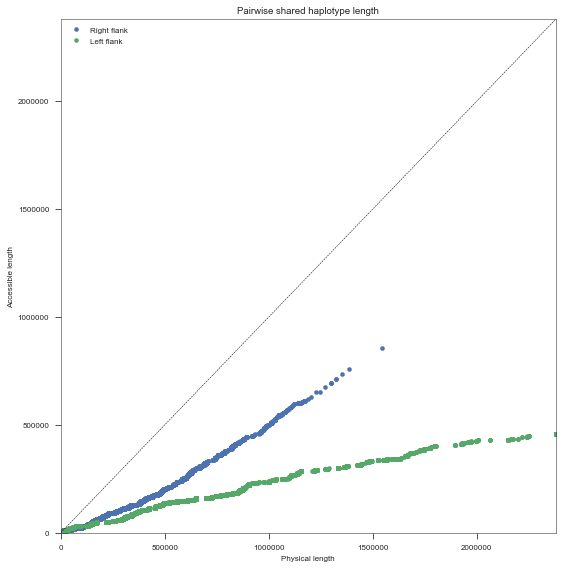

In [74]:
# check again accessibility

fig, ax = plt.subplots(figsize=(8, 8))
x = pspd_right
y = pspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = pspd_left
y = pspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Pairwise shared haplotype length')
fig.tight_layout();

check recombination rate on left vs. right flank

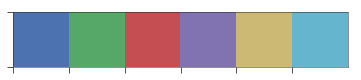

In [75]:
palette = sns.color_palette()
sns.palplot(palette);

x    0.369112
dtype: float64

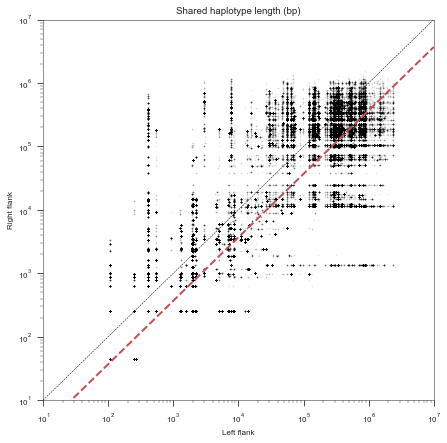

In [76]:
# compare shared haplotype length on left versus right flanks

x = pspd_left
y = pspd_right

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1e1, 1e7

df = pandas.DataFrame({'x': x, 'y': y})
# linear regression
r = sfa.ols('y ~ x + 0', data=df).fit()
# plot the regression line
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('Shared haplotype length (bp)')
ax.set_xscale('log')
ax.set_yscale('log')
r.params

x    0.997601
dtype: float64

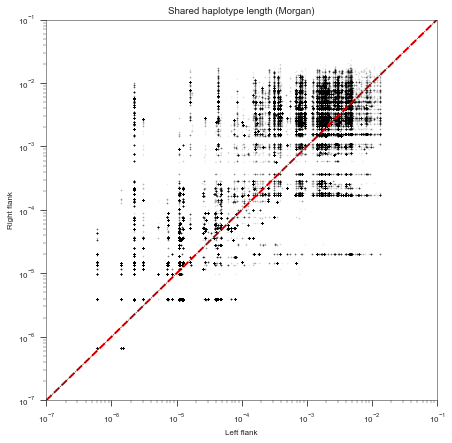

In [77]:
# compare shared haplotype length after applying adjustment for different 
# recombination rates on left and right flanks

x = pspd_left * rr_left
y = pspd_right * rr_right

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1e-7, 1e-1

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('Shared haplotype length (Morgan)')
ax.set_xscale('log')
ax.set_yscale('log')
r.params

In [78]:
# check where the heterochromatin boundary is supposed to be
phase1_ar3.tbl_chromatin

0|name,1|chrom,2|start,3|stop
CHX,X,20009764,24393108
CH2R,2R,58984778,61545105
CH2L,2L,1,2431617
PEU2L,2L,2487770,5042389
IH2L,2L,5078962,5788875


x    1.630348
dtype: float64

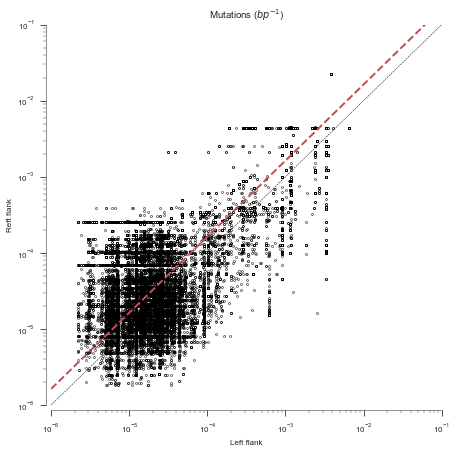

In [79]:
# check mutation rate on left versus right flank.

x = pmuts_left / pspd_left_accessible
y = pmuts_right / pspd_right_accessible
tst = (x > 0) & (y > 0)
x = x[tst]
y = y[tst]

lim = 1e-6, 1e-1
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(x, y, marker='o', markersize=2, mfc='none', mec='k', linestyle=' ')

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, linestyle='--', color='k')
ax.set_title('Mutations ($bp^{-1}$)')
ax.set_xlabel('Left flank')
ax.set_ylabel('Reft flank')
r.params

x    0.994513
dtype: float64

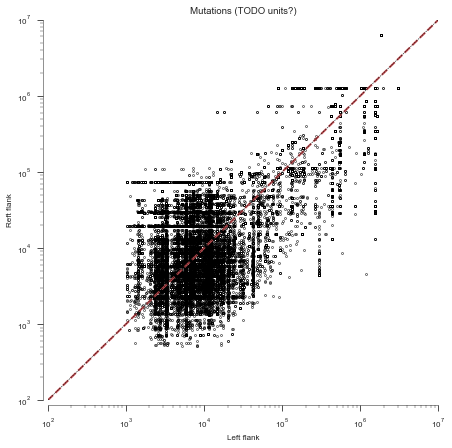

In [80]:
# check mutations on left versus right flank after correcting mutation rate

x = pmuts_left / (mu_left * pspd_left_accessible)
y = pmuts_right / (mu_right * pspd_right_accessible)
tst = (x > 0) & (y > 0)
x = x[tst]
y = y[tst]

lim = 1e2, 1e7
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(x, y, marker='o', markersize=2, mfc='none', mec='k', linestyle=' ')

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, linestyle='--', color='k')
ax.set_title('Mutations (TODO units?)')
ax.set_xlabel('Left flank')
ax.set_ylabel('Reft flank')
r.params

x    1.001761
dtype: float64

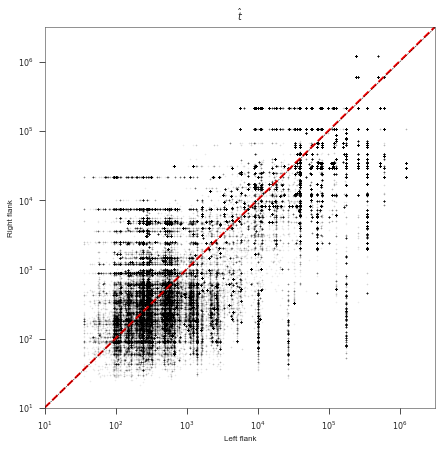

In [81]:
# now compare estimats of t_hat on left and right flanks, using all adjustments

pt_hat_left = (1 + pmuts_left) / (2 * (pspd_left * rr_left + pspd_left_accessible * mu_left))
pt_hat_right = (1 + pmuts_right) / (2 * (pspd_right * rr_right + pspd_right_accessible * mu_right))
x = np.log10(pt_hat_left)
y = np.log10(pt_hat_right)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1, 6.5

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('$\hat{t}$')
ticks = np.arange(lim[0], int(lim[1]) + 1)
ticklabels = ['$10^{%s}$' % t for t in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
r.params

In [82]:
pspd_both = pspd_left + pspd_right
pmuts_both = pmuts_left + pmuts_right
psgl_both = pspd_left * rr_left + pspd_right * rr_right
psml_both = pspd_left_accessible * mu_left + pspd_right_accessible * mu_right
pt_hat_both = (1 + pmuts_both) / (2 * (psgl_both + psml_both))

# dendrogram visualisation and clustering

In [83]:
def plot_dendrogram(dist, cut_height=1e3, yscale='log', ylim=(10, 1e6), linkage_method='average',
                    n_clusters=14):
    """This function plots a dendrogram using scipy and provides some utilities for annotating clusters."""
    
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    fig = plt.figure(figsize=(16, 8), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, .5, 4], hspace=0)

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True, 
        color_threshold=0, 
        above_threshold_color='k',
        ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes), 200)) + [len(df_haplotypes)])
    xticks = xticklabels / len(df_haplotypes)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')

    cluster_palette = sns.color_palette('Set3', n_colors=12)
    if cut_height:
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        ixs = np.argsort([min(cl) for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
#             ax.axvline(x1*10, color='k', linestyle='--')
#             ax.axvline(x2*10, color='k', linestyle='--')
            ax.fill_between([x1*10, x2*10], 0, cut_height, color=color, alpha=.4, zorder=20)
#             ax.axvspan(x1*10, x2*10, color=color, zorder=-20, alpha=.5)
            ax.text((x1*10 + x2*10) / 2, ylim[0], str(i), ha='center', va='top')
        
    ax = fig.add_subplot(gs[1], )
    sns.despine(ax=ax, left=True, bottom=True)
    pops = df_haplotypes.population[r['leaves']]
    pop_colors = [phase1_ar3.pop_colors[p] for p in pops]
    ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_yticks([])
    ax.set_ylabel('Population', rotation=0, ha='right', va='center')
    ax.set_xticks([])
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)

    ax = fig.add_subplot(gs[2])
    hapclust.plot_haplotypes(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_xlabel('Haplotypes')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)
            ax.axvspan(x1, x2, color=color, zorder=20, alpha=.4)

    gs.tight_layout(fig, h_pad=0)
    return clusters

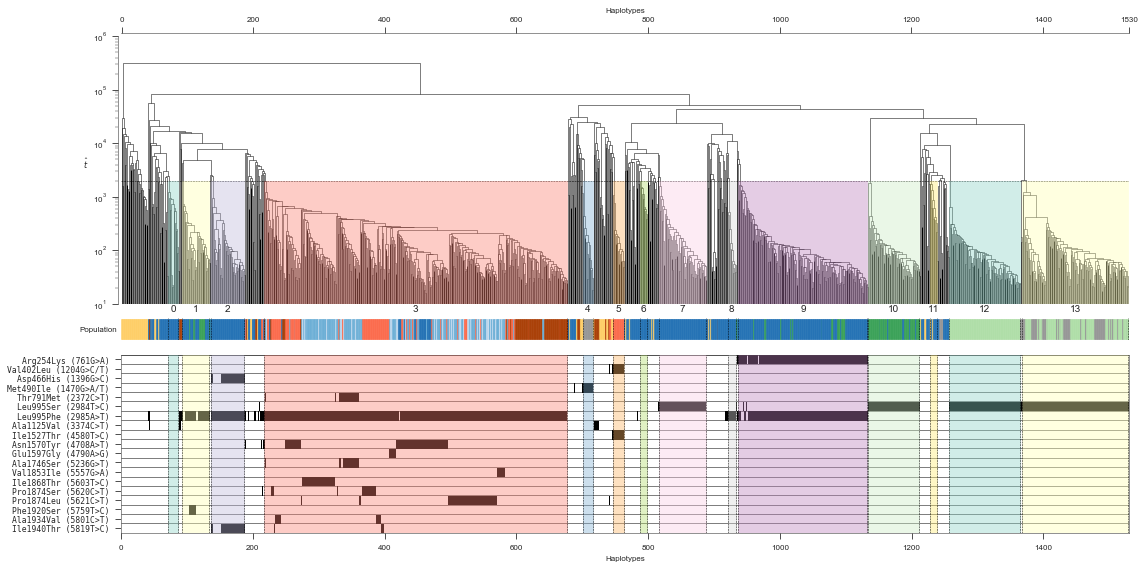

In [84]:
# canonical dendrogram we'll use for cluster analyses
clusters = plot_dendrogram(pt_hat_both, cut_height=2e3)

In [85]:
len(clusters)

14

In [86]:
cluster_names = {
    1 : 'F4',
    2 : 'F3',
    3 : 'F1',
    4 : 'L1',
    5 : 'L2',
    7 : 'S4/5',
    8 : 'F2',
    9 : 'F5',
    10 : 'S2',
    12 : 'S1',
    13 : 'S3'
}

# Output the haplogroup indices for use elsewhere

need to fix these names to match the Ag1000g paper;

##### new - Ag1000g

- F1 - F4
- F2 - F3
- F3 - F1
- F4 - F2
- F5 - F5

- L1 - NA
- L2 - NA

- S1 - S4/5
- S2 - S2
- S3 - S1
- S4 - S3 

In [87]:
#subset dict
clusters_good = {k: clusters[k] for k in cluster_names.keys()}

In [89]:
#check
clusters_good[5], len(clusters_good)

({2,
  9,
  11,
  34,
  38,
  75,
  135,
  149,
  157,
  170,
  186,
  208,
  226,
  237,
  251,
  261,
  266,
  269},
 11)

In [90]:
#change dict names to clusters i.e. 2 = 'F1'
for k, n in zip(list(cluster_names.keys()), list(cluster_names.values())):
    clusters_good[n] = clusters_good.pop(k)

In [91]:
#check new dict
for k, n in zip(cluster_names.keys(), cluster_names.values()):
    print(clusters[k] == clusters_good[n])

True
True
True
True
True
True
True
True
True
True
True


In [92]:
#save as pickle
import pickle
with open('../data/clust_dict.pickle', 'wb') as handle:
    pickle.dump(clusters_good, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
#check pickle
with open('../data/clust_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(clusters_good == b)

True


In [94]:
len(clusters_good.values())

11

In [95]:
#make list of all indices (values) and their cluster names (keys) in clusters_good 
all_idx = []
all_clu = []
for c in clusters_good.keys():
    for i in list(clusters_good[c]):
        all_clu.append(c)
        all_idx.append(i)
        
len(all_idx), len(all_clu)

(1220, 1220)

In [96]:
#write out text file
clus_df = pandas.DataFrame()
clus_df['cluster'] = all_clu
clus_df['haplotype'] = all_idx
clus_df.to_csv('../data/clusters.txt', sep='\t', index=False)

# cladogram figure 1a
- use our own cladogram implementation
- colour 995, 1570 mutations red, split colours of multiallelics
- add vspans for haplogroups using code from Ag1000g-fig5 - HGs are any clusters with non-syn mutations in.

In [97]:
populations = ('AOM', 'BFM', 'GWA', 'GNS', 'BFS', 'CMS', 'GAS', 'UGS', 'KES')

pop_colours = {
    'AOM': sns.color_palette('YlOrBr', 5)[4],
    'BFM': sns.color_palette('Reds', 3)[1],
    'GWA': sns.color_palette('YlOrBr', 5)[1],
    'GNS': sns.color_palette('Blues', 3)[0],
    'BFS': sns.color_palette('Blues', 3)[1],
    'CMS': sns.color_palette('Blues', 3)[2],
    'UGS': sns.color_palette('Greens', 2)[0],
    'GAS': sns.color_palette('Greens', 2)[1],
    'KES': sns.color_palette('Greys', 5)[2],
}

pop_labels = {
    'AOM': 'AO $coluzzii$',
    'BFM': 'BF $coluzzii$',
    'GWA': 'GW',
    'GNS': 'GN $gambiae$',
    'BFS': 'BF $gambiae$',
    'CMS': 'CM $gambiae$',
    'UGS': 'UG $gambiae$',
    'GAS': 'GA $gambiae$',
    'KES': 'KE'
}


In [98]:
lbl_vgsc_missense

['Arg254Lys (761G>A)',
 'Val402Leu (1204G>C/T)',
 'Asp466His (1396G>C)',
 'Met490Ile (1470G>A/T)',
 'Thr791Met (2372C>T)',
 'Leu995Ser (2984T>C)',
 'Leu995Phe (2985A>T)',
 'Ala1125Val (3374C>T)',
 'Ile1527Thr (4580T>C)',
 'Asn1570Tyr (4708A>T)',
 'Glu1597Gly (4790A>G)',
 'Ala1746Ser (5236G>T)',
 'Val1853Ile (5557G>A)',
 'Ile1868Thr (5603T>C)',
 'Pro1874Ser (5620C>T)',
 'Pro1874Leu (5621C>T)',
 'Phe1920Ser (5759T>C)',
 'Ala1934Val (5801C>T)',
 'Ile1940Thr (5819T>C)']

In [99]:
#split colours of multiallelics
def plot_haplotypes_split(ax, h, mut_labels=None):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k', 'b'] 
    # alter rows with kdr mutations for color map to pick up
    known_muts = ['Leu995Ser (2984T>C)', 'Leu995Phe (2985A>T)']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=4)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=2)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    ax.set_yticklabels(mut_labels[::-1],family = 'monospace')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xlabel('haplotypes')
    ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    ax.xaxis.tick_bottom()

In [104]:
[cluster_names.keys()]

[dict_keys([1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13])]

In [105]:
def plot_cladogram(dist, yscale='symlog', yscale_kws=None, ylim=(10, 1e6), count_sort=True, cut_height=2e3,
                   linkage_method='average', n_clusters=14, fill_threshold=0, leaf_height=0, linewidth=2):
    
    # perform hierarchical clustering
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
    # needed for getting leaves in right order
    r = scipy.cluster.hierarchy.dendrogram(
        z, count_sort=count_sort, no_plot=True)

    # setup figure
    fig = plt.figure(figsize=(16, 8), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, 4, 0.4], hspace=None)
    
    # setup  vspans - find clusters
    f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
    # compute cluster sizes
    fsz = np.bincount(f)
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    # take largest n
    fsort = fsort[:n_clusters]
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster]) for cluster in clusters]
    ixs = np.argsort([min(cl) for cl in clusters_leaves])
    clusters = [clusters[i] for i in ixs]
    clusters_leaves = [clusters_leaves[i] for i in ixs]
    
#----------------------------------------------------------------------------------------------------------------------

    # plot cladogram
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    colors = [phase1_ar3.pop_colors[p] for p in df_haplotypes.population]
    hapclust.cladogram(z, count_sort=True, colors=colors, 
                       fill_threshold=fill_threshold, leaf_height=leaf_height, 
                       plot_kws=dict(linewidth=linewidth), 
                       fill_kws=dict(linewidth=linewidth), 
                       ax=ax)
    ax.set_ylim(*ylim)
    if yscale_kws is None:
        yscale_kws = dict()
    ax.set_yscale(yscale, **yscale_kws)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(r['leaves']), 200)) + [len(r['leaves'])])
    xticks = xticklabels / len(r['leaves'])
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks([])
    #ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')
    ax.grid(axis='y', linestyle='--', zorder=-1e9)
    ax.axhline(cut_height, linestyle='--', linewidth=1, color='r')
    
    #legend
    allpop = list(phase1_ar3.pop_colors.keys())
    ninepop = allpop.remove('colony')
    #ninecol = [phase1_ar3.pop_colors[p] for p in ninepop]
    handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
    ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3, prop={'size':10})
    
#-----------------------------------------------------------------------------------------------------------------------  
        
    # plot display haplotypes
    ax = fig.add_subplot(gs[1])
    plot_haplotypes_split(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(r['leaves']))
    ax.set_xticks([])
    ax.set_xlabel('')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13]:
                x1, x2 = min(cluster_leaves), max(cluster_leaves)
                ax.axvline(x1, color='k', linestyle='--', zorder=20)
                ax.axvline(x2, color='k', linestyle='--', zorder=20)
                ax.axvspan(x1, x2, color='k', zorder=20, alpha=.1)
    
#-----------------------------------------------------------------------------------------------------------------------

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[2])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, 1530)
    ax_clu.set_ylim(0, 1)
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13]:
                xmin, xmax = min(cluster_leaves), max(cluster_leaves)
                fraction = -20 / (xmax - xmin)
                ax_clu.annotate("", ha='left', va='center',
                                xy=(xmin, 1), xycoords='data',
                                xytext=(xmax, 1), textcoords='data',
                                arrowprops=dict(arrowstyle="-",
                                                connectionstyle="bar,fraction=%.4f" % fraction,
                                                ),
                                )
                ax_clu.text((xmax + xmin)/2, 0, cluster_names[i], va='top', ha='center')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplogroups', labelpad=8)
                  
#--------------------------------------------------------------------------------------------------------------------------

    gs.tight_layout(fig, h_pad=-0.8)
    fn = '../artwork/Figure_1a_Clado.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=300, bbox_inches='tight')

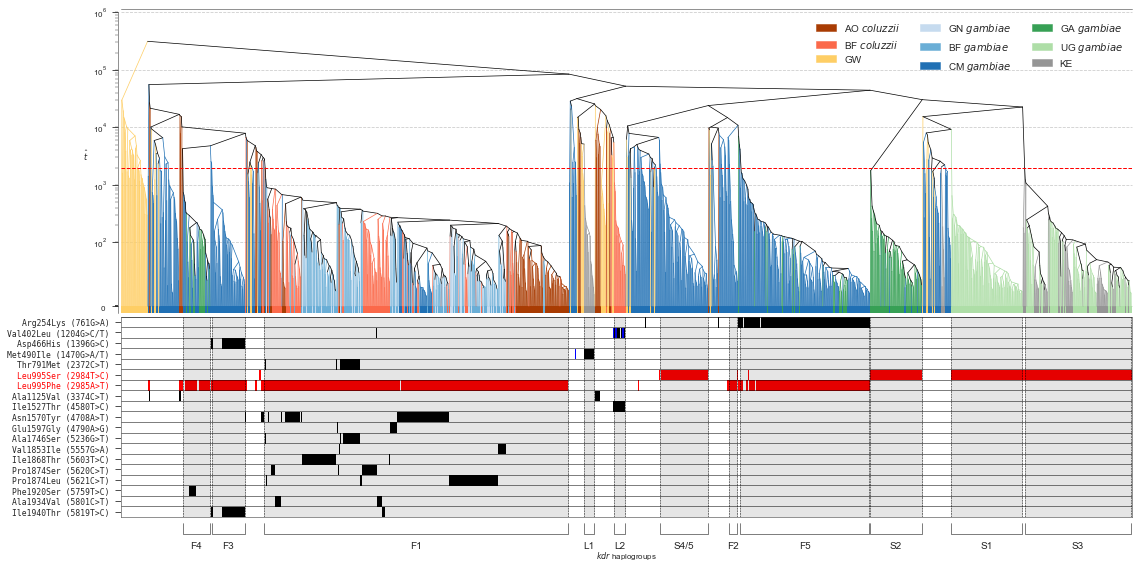

In [106]:
plot_cladogram(pt_hat_both, fill_threshold=0, linewidth=0.7, leaf_height=100,
               ylim=(-10, 1e6), yscale='symlog', yscale_kws=dict(linthreshy=100, linscaley=1.0, subsy=list(range(1, 10))))